### How can we convert the pdb graph to glycowork graph?


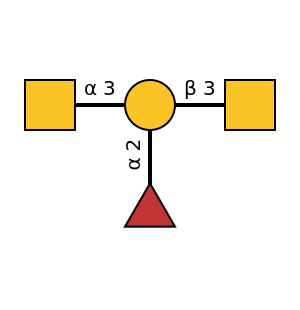

In [2]:
from glycowork.motif.draw import GlycoDraw

GlycoDraw("Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-3)GalNAc")

## Glycowork graph

In [3]:
from glycowork.motif.graph import  glycan_to_nxGraph

glycan_to_nxGraph('Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-3)GalNAc').__dict__


{'graph': {},
 '_node': {0: {'string_labels': 'Fuc'},
  1: {'string_labels': 'a1-2'},
  2: {'string_labels': 'GalNAc'},
  3: {'string_labels': 'a1-3'},
  4: {'string_labels': 'Gal'},
  5: {'string_labels': 'b1-3'},
  6: {'string_labels': 'GalNAc'}},
 '_adj': {0: {1: {}},
  1: {0: {}, 4: {}},
  2: {3: {}},
  3: {2: {}, 4: {}},
  4: {1: {}, 3: {}, 5: {}},
  5: {4: {}, 6: {}},
  6: {5: {}}},
 '__networkx_cache__': {},
 'edges': EdgeView([(0, 1), (1, 4), (2, 3), (3, 4), (4, 5), (5, 6)]),
 'nodes': NodeView((0, 1, 2, 3, 4, 5, 6))}

## PDB graph

In [4]:
import pickle
def load_data_pdb():
    flex_data_path = '/Users/xakdze/PycharmProjects/GlyContact_analyses/data/glycan_graphs.pkl'

    """Load glycan flexibility data and binding data."""
    with open(flex_data_path, 'rb') as file:
        flex_data = pickle.load(file)
    return flex_data

flex_data_pdb=  load_data_pdb()

flex_data_pdb["Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-3)GalNAc"].__dict__

{'graph': {},
 '_node': {5: {'Monosaccharide': 'Fuc(a1-2)',
   'Mean Score': 1.7742241196567192,
   'Median Score': 1.7500426049227826,
   'Weighted Score': 1.770798686109169,
   'weighted_mean_flexibility': 1.7841829199999972},
  3: {'Monosaccharide': 'Gal(b1-3)',
   'Mean Score': 1.3651039792224764,
   'Median Score': 1.4288511350750923,
   'Weighted Score': 1.4280285533756016,
   'weighted_mean_flexibility': 0.5045951200000001},
  2: {'Monosaccharide': 'GalNAc(b1-1)',
   'Mean Score': 2.570391431148164,
   'Median Score': 2.5758022993104532,
   'Weighted Score': 2.5724899762541984,
   'weighted_mean_flexibility': 1.0605134599999986},
  1: {'Monosaccharide': '-R',
   'Mean Score': 0.4371745139360428,
   'Median Score': 0.4432986080646515,
   'Weighted Score': 0.4489135126680136,
   'weighted_mean_flexibility': 1.9624109399999994},
  4: {'Monosaccharide': 'GalNAc(a1-3)',
   'Mean Score': 3.1187803193926813,
   'Median Score': 3.120820430573076,
   'Weighted Score': 3.145775448013074,


## Convert pdb graph to glycowork graph

In [17]:
import networkx as nx

def convert_pdb_graph_to_glycowork(g):
    """
    Converts a PDB-format graph to glycowork format and compares each node index's string_labels
    between the converted pdb graph and glycowork graph to find differences.

    Args:
        g (nx.Graph): Input graph in PDB format with Monosaccharide and score attributes.

    Returns:
        nx.Graph: Converted graph in glycowork format with monosaccharide/linkage split into separate nodes.
    """
    new_g = nx.Graph()

    # Find reducing end (node connected to -R node 1)
    reducing_end = next(iter(g.neighbors(1)), None)
    if reducing_end is None:
        raise ValueError("Could not find reducing end (node connected to -R).")

    # Get node list in DFS order starting from reducing end (excluding -R node)
    nodes = [n for n in nx.dfs_preorder_nodes(g, reducing_end) if n != 1]

    # Create mapping dict
    mapping = {}
    mapping[1] = []  # -R maps to nothing

    # Calculate highest node number
    max_num = 2 * (len(g.nodes) - 2)

    # Map reducing end to highest number
    mapping[reducing_end] = [max_num]

    # Map rest of nodes in reverse order
    curr_num = 0
    for node in reversed(nodes[1:]):  # Skip reducing end
        mapping[node] = [curr_num, curr_num + 1]
        curr_num += 2

    # Create nodes in new graph
    for old_node, new_nodes in mapping.items():
        if not new_nodes:  # Skip -R
            continue

        # Get numerical attributes
        attrs = {k: v for k, v in g.nodes[old_node].items()
                 if k not in ['Monosaccharide', 'string_labels']}
        mono_link = g.nodes[old_node]['Monosaccharide']

        if len(new_nodes) == 1:  # Reducing end
            mono = mono_link.split('(')[0]
            new_g.add_node(new_nodes[0], string_labels=mono, **attrs)
        else:  # Normal nodes
            mono = mono_link.split('(')[0]
            link = mono_link.split('(')[1][:-1]

            new_g.add_node(new_nodes[0], string_labels=mono, **attrs)
            new_g.add_node(new_nodes[1], string_labels=link, **attrs)
            new_g.add_edge(new_nodes[0], new_nodes[1])

    # Add edges between components
    for old_u, old_v in g.edges():
        new_u = mapping.get(old_u, [])
        new_v = mapping.get(old_v, [])

        if not new_u or not new_v:  # Skip if either is -R
            continue

        if len(new_u) == 1:  # u is reducing end
            u_node = new_u[0]
        else:
            u_node = new_u[0]  # Use monosaccharide node

        if len(new_v) == 1:  # v is reducing end
            v_node = new_v[0]
        else:
            v_node = new_v[1]  # Use linkage node

        new_g.add_edge(u_node, v_node)

    # Compare string_labels between pdb_graph and glycowork_graph
    pdb_nodes = {n: g.nodes[n]['Monosaccharide'].split('(')[0] for n in g.nodes if 'Monosaccharide' in g.nodes[n]}
    glyco_nodes = {n: new_g.nodes[n]['string_labels'] for n in new_g.nodes}

    # Find and print differences
    differences = []
    for idx, label in glyco_nodes.items():
        if idx in pdb_nodes and pdb_nodes[idx] != label:
            differences.append((idx, pdb_nodes[idx], label))

    if differences:
        print("Differences found between pdb_graph and glycowork_graph:")
        for diff in differences:
            print(f"Node Index {diff[0]}: pdb_graph='{diff[1]}', glycowork_graph='{diff[2]}'")
    else:
        print("No differences found between pdb_graph and glycowork_graph.")

    return new_g


In [18]:
convert_pdb_graph_to_glycowork(flex_data_pdb["Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-3)GalNAc"]).__dict__

Differences found between pdb_graph and glycowork_graph:
Node Index 1: pdb_graph='-R', glycowork_graph='a1-3'
Node Index 2: pdb_graph='GalNAc', glycowork_graph='Fuc'
Node Index 3: pdb_graph='Gal', glycowork_graph='a1-2'
Node Index 4: pdb_graph='GalNAc', glycowork_graph='Gal'
Node Index 5: pdb_graph='Fuc', glycowork_graph='b1-3'


{'graph': {},
 '_node': {6: {'string_labels': 'GalNAc',
   'Mean Score': 2.570391431148164,
   'Median Score': 2.5758022993104532,
   'Weighted Score': 2.5724899762541984,
   'weighted_mean_flexibility': 1.0605134599999986},
  0: {'string_labels': 'GalNAc',
   'Mean Score': 3.1187803193926813,
   'Median Score': 3.120820430573076,
   'Weighted Score': 3.145775448013074,
   'weighted_mean_flexibility': 1.7962038799999962},
  1: {'string_labels': 'a1-3',
   'Mean Score': 3.1187803193926813,
   'Median Score': 3.120820430573076,
   'Weighted Score': 3.145775448013074,
   'weighted_mean_flexibility': 1.7962038799999962},
  2: {'string_labels': 'Fuc',
   'Mean Score': 1.7742241196567192,
   'Median Score': 1.7500426049227826,
   'Weighted Score': 1.770798686109169,
   'weighted_mean_flexibility': 1.7841829199999972},
  3: {'string_labels': 'a1-2',
   'Mean Score': 1.7742241196567192,
   'Median Score': 1.7500426049227826,
   'Weighted Score': 1.770798686109169,
   'weighted_mean_flexibility

In [14]:
## test

In [30]:
def create_glycontact_annotated_graph(glycan):
    gw_graph = glycan_to_nxGraph(glycan)
    mapper = {}
    num_nodes = len(gw_graph)-1
    for gwork,gcontact in zip(range(num_nodes,-1,-2),range(2,num_nodes)):
        mapper[gcontact] = gwork
    try:
        flex_score_dict = nx.get_node_attributes(flex_data_pdb[glycan],'weighted_mean_flexibility')
    except KeyError:
        raise KeyError('This glycan is not present in the flex database')
    gw_flex_score_dict = {mapper[gcontact_node]:score for gcontact_node,score in flex_score_dict.items() if gcontact_node in mapper}
    nx.set_node_attributes(gw_graph,gw_flex_score_dict,'weighted_mean_flexibility')
    return gw_graph

create_glycontact_annotated_graph("Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)GlcNAc(b1-3)[Fuc(a1-2)[Gal(a1-3)]Gal(b1-4)GlcNAc(b1-6)]GalNAc").__dict__


{'graph': {},
 '_node': {0: {'string_labels': 'Fuc',
   'weighted_mean_flexibility': 19.47464246666666},
  1: {'string_labels': 'a1-2'},
  2: {'string_labels': 'Gal', 'weighted_mean_flexibility': 18.736587200000002},
  3: {'string_labels': 'a1-3'},
  4: {'string_labels': 'Gal', 'weighted_mean_flexibility': 13.830288533333333},
  5: {'string_labels': 'b1-4'},
  6: {'string_labels': 'GlcNAc',
   'weighted_mean_flexibility': 11.88888013333333},
  7: {'string_labels': 'b1-3'},
  8: {'string_labels': 'Fuc', 'weighted_mean_flexibility': 15.140066866666654},
  9: {'string_labels': 'a1-2'},
  10: {'string_labels': 'Gal',
   'weighted_mean_flexibility': 21.699575199999998},
  11: {'string_labels': 'a1-3'},
  12: {'string_labels': 'Gal',
   'weighted_mean_flexibility': 11.780021066666663},
  13: {'string_labels': 'b1-4'},
  14: {'string_labels': 'GlcNAc',
   'weighted_mean_flexibility': 8.039970133333334},
  15: {'string_labels': 'b1-6'},
  16: {'string_labels': 'GalNAc',
   'weighted_mean_flexi

In [5]:
flex_data_pdb["Fuc(a1-2)Gal(b1-4)[Fuc(a1-3)]GlcNAc(b1-3)[Fuc(a1-3)[Gal(b1-4)]GlcNAc(b1-6)]Gal(b1-4)Glc"].__dict__

{'graph': {},
 '_node': {2: {'Monosaccharide': 'Glc(b1-1)',
   'Mean Score': 2.0514767858432608,
   'Median Score': 2.244769612327218,
   'Weighted Score': 2.128792897366927,
   'weighted_mean_flexibility': 12.17857534246575},
  1: {'Monosaccharide': '-R',
   'Mean Score': 0.46870365738868713,
   'Median Score': 0.5194512158632278,
   'Weighted Score': 0.492240047726902,
   'weighted_mean_flexibility': 21.947800819918005},
  4: {'Monosaccharide': 'GlcNAc(b1-6)',
   'Mean Score': 1.773262549820356,
   'Median Score': 1.6837695762515068,
   'Weighted Score': 1.7021496458169612,
   'weighted_mean_flexibility': 17.064866673332663},
  3: {'Monosaccharide': 'Gal(b1-4)',
   'Mean Score': 1.0813572494313122,
   'Median Score': 1.0846662780968472,
   'Weighted Score': 1.0457681036238264,
   'weighted_mean_flexibility': 6.275166123387661},
  8: {'Monosaccharide': 'Gal(b1-4)',
   'Mean Score': 1.7647929069120436,
   'Median Score': 1.7578037350904197,
   'Weighted Score': 1.7861381799561076,
   '